<a href="https://colab.research.google.com/github/Bprs68/Rossmann-Sales-Prediction-/blob/main/Notebook_3_Random_Forest_Hyperparameter_Tuning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.9.2
Running on TPU  ['10.83.151.178:8470']


In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import math


import warnings    
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/AlmaBetter/Capstone Projects/Capstone Project - Supervised Machine Learning- Regression/cleaned_data/'

In [ ]:
train_df = pd.read_csv(file_path+'train.csv')

In [ ]:
test_df = pd.read_csv(file_path+'test.csv')

In [ ]:
#setting date and store as index
train_df.set_index(['Date','Store'], inplace=True)
train_df.sort_values(by=['Date','Store'], inplace=True)

test_df.set_index(['Date','Store'], inplace=True)
test_df.sort_values(by=['Date','Store'], inplace=True)

In [ ]:
train_df.head(1)

,,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,WeekOfYear,DayOfYear,CompetitionOpen,Promo2Open,Promo2running
Date,Store,,,,,,,,,,,,,,,,,
2013-01-01,85,2,8.34759,619,0,1,1,b,a,1870.0,0,2013,1,1,1,15.0,0.0,0


In [ ]:
train_df.columns

Index(['DayOfWeek', 'Sales', 'Customers', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'Promo2', 'Year', 'Month', 'WeekOfYear', 'DayOfYear', 'CompetitionOpen',
       'Promo2Open', 'Promo2running'],
      dtype='object')

In [ ]:
test_df.head(1)

,,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,WeekOfYear,DayOfYear,CompetitionOpen,Promo2Open,Promo2running
Date,Store,,,,,,,,,,,,,,,,,
2015-06-15,1,1,8.615771,586,1,0,0,c,a,1270.0,0,2015,6,25,166,81.0,0.0,0


## Test-Train-Split

In [ ]:
# dividing train df into train_x and train_y 
X_train = train_df.drop('Sales', axis=1)
y_train = train_df[['Sales']]

#dividing test df into test_x and test_y
X_test = test_df.drop("Sales", axis=1)
y_test = test_df[['Sales']]

One Hot Encoding of categorical columns to conver them into numerical columns

In [ ]:
# making a list of categorical columns
Categorical_columns = ['DayOfWeek','StoreType','Assortment']

In [ ]:
# assigning one hot encoder
enc = OneHotEncoder(sparse=False)

In [ ]:
enc.fit(X_train[Categorical_columns])

OneHotEncoder(sparse=False)

In [ ]:
# getting a new list of encoded columns from Categorical_columns in train data
encoded_cols = enc.get_feature_names(Categorical_columns).tolist()

In [ ]:
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [ ]:
#performing transformation on training data and creating new features for encoded columns
X_train[encoded_cols] = enc.transform(X_train[Categorical_columns])

In [ ]:
#dropping old categorical columns from training data
X_train.drop(Categorical_columns, axis=1, inplace=True)

In [ ]:
#performing transformation on testing data and creating new features for encoded columns
X_test[encoded_cols] = enc.transform(X_test[Categorical_columns])

In [ ]:
#dropping old categorical columns from testing data
X_test.drop(Categorical_columns, axis=1, inplace=True)

In [ ]:
X_train.columns

Index(['Customers', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'CompetitionDistance', 'Promo2', 'Year', 'Month', 'WeekOfYear',
       'DayOfYear', 'CompetitionOpen', 'Promo2Open', 'Promo2running',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a',
       'Assortment_b', 'Assortment_c'],
      dtype='object')

### **Time for transformations in our data**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[list(X_train.columns)] = scaler.fit_transform(X_train[list(X_train.columns)])
X_test[list(X_test.columns)] = scaler.fit_transform(X_test[list(X_test.columns)])

scaler = StandardScaler()
y_train[list(y_train.columns)] = scaler.fit_transform(y_train[list(y_train.columns)])
y_test[list(y_test.columns)] = scaler.transform(y_test[list(y_train.columns)])

In [ ]:
# importing evaluation matrices
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



As expected high bias and high variance.

**Hyperparameter Tuning**

In [ ]:
# importing random forest from ScikitLearn
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rf_tuned = RandomForestRegressor(random_state=68)

In [ ]:
from scipy.stats import randint

rs_space={'max_depth':[100,150,None],
              'n_estimators':[100,150,200],
              'max_features':['auto','sqrt'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

In [ ]:
rf_t= RandomizedSearchCV(estimator = rf_tuned, param_distributions = rs_space, n_iter = 10, cv = 3, verbose=2, random_state=68)

rf_t.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time= 1.6min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time= 1.7min
[CV] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time= 6.7min
[CV] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time= 6.7min
[CV] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time= 6.8min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time= 6.7min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_e

KeyboardInterrupt: ignored

In [ ]:
# assigning to variable
params = model_random.best_params_

In [ ]:
# assigning variable with tuned params
rf_tuned = RandomForestRegressor(max_depth = None, max_features = 'auto', min_samples_leaf=1, n_estimators=150)

In [ ]:
# fitting on training data
rf_tuned.fit(X_train,y_train)

RandomForestRegressor(n_estimators=150)

In [ ]:
# predicting train_y
y_pred_train_rft = rf_tuned.predict(X_train)

In [ ]:
# predicting test_y
y_pred_test_rft = rf_tuned.predict(X_test)

In [ ]:
# importing evaluation matrices
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# printing evaluation matrices for our model
print(f'r2_score for training data is {r2_score(y_pred_train_rft,y_train)}')
print(f'r2_score for testing data is {r2_score(y_pred_test_rft,y_test)}')

print(f'Adjusted r2_score for training data is {round(1 - (1-r2_score(y_train, y_pred_train_rft)) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1),6)}')
print(f'Adjusted r2_score for testing data is {round(1 - (1-r2_score(y_test, y_pred_test_rft)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),6)}')

print(f'Mean Absolute Error for training data is {mean_absolute_error(y_pred_train_rft,y_train)}')
print(f'Mean Absolute Error for testing data is {mean_absolute_error(y_pred_test_rft,y_test)}')

print(f'Mean Squared Error for training data is {mean_squared_error(y_pred_train_rft,y_train)}')
print(f'Mean Squared Error for testing data is {mean_squared_error(y_pred_test_rft,y_test)}')

print(f'Root Mean Squared Error for training data is {math.sqrt(mean_squared_error(y_pred_train_rft,y_train))}')
print(f'Root Mean Squared Error for testing data is {math.sqrt(mean_squared_error(y_pred_test_rft,y_test))}')

r2_score for training data is 0.9964959866218832
r2_score for testing data is 0.9510325693402717
Adjusted r2_score for training data is 0.996559
Adjusted r2_score for testing data is 0.952444
Mean Absolute Error for training data is 0.04303401885599208
Mean Absolute Error for testing data is 0.15356758314945565
Mean Squared Error for training data is 0.0034405745621451577
Mean Squared Error for testing data is 0.04476980798655872
Root Mean Squared Error for training data is 0.05865641109158621
Root Mean Squared Error for testing data is 0.21158877093683096


In [ ]:
comparison_df = pd.read_csv(file_path+'comparison_df.csv')

In [ ]:
math.sqrt(mean_squared_error(y_pred_test_rft,y_test))

0.21158877093683096

In [ ]:
comparison_df_rf_Tune = pd.DataFrame({'Model_name':'Random Forest Tuned',
                                      'Variable':'rf_tuned', 
                                     'Train_r2':r2_score(y_pred_train_rft,y_train),	
                                     'Test_r2':r2_score(y_pred_test_rft,y_test),	
                                     'Train_adjusted_r2':round(1 - (1-r2_score(y_train, y_pred_train_rft)) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1),6),
                                     'Test_adjusted_r2':round(1 - (1-r2_score(y_test, y_pred_test_rft)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),6),
                                     'Train_MAE':mean_absolute_error(y_pred_train_rft,y_train),
                                     'Test_MAE':mean_absolute_error(y_pred_test_rft,y_test),
                                     'Train_MSE':mean_squared_error(y_pred_train_rft,y_train),
                                     'Test_MSE': mean_squared_error(y_pred_test_rft,y_test),
                                     	'Train_RMSE':math.sqrt(mean_squared_error(y_pred_train_rft,y_train)),
                                      'Test_RMSE':math.sqrt(mean_squared_error(y_pred_test_rft,y_test))}, index=[0])

In [ ]:
comparison_df_rf_Tune

,Model_name,Variable,Train_r2,Test_r2,Train_adjusted_r2,Test_adjusted_r2,Train_MAE,Test_MAE,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE
0,Random Forest Tuned,rf_tuned,0.996496,0.951033,0.996559,0.952444,0.043034,0.153568,0.003441,0.04477,0.058656,0.211589


In [ ]:
updated_comparison_df = pd.concat([comparison_df, comparison_df_rf_Tune], axis=0)

In [ ]:
updated_comparison_df 

,Unnamed: 0,Model_name,Variable,Train_r2,Test_r2,Train_adjusted_r2,Test_adjusted_r2,Train_MAE,Test_MAE,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE
0,0.0,Decision Tree,dtree,0.999999,0.913278,0.999999,0.911298,0.000004,0.205404,0.000001,0.083506,0.001116,0.288973
1,1.0,Random Forest Regressor,rf,0.996436,0.950859,0.996500,0.952252,0.043342,0.153875,0.003500,0.044951,0.059162,0.212016
2,2.0,LightGradient Boost Regressor,lgbm_reg,0.915696,0.885444,0.925448,0.896417,0.214867,0.245587,0.074550,0.097514,0.273038,0.312273
0,NaN,Random Forest Tuned,rf_tuned,0.996496,0.951033,0.996559,0.952444,0.043034,0.153568,0.003441,0.044770,0.058656,0.211589


In [ ]:
updated_comparison_df.drop(columns =['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
updated_comparison_df.reset_index(inplace=True)

In [ ]:
updated_comparison_df.drop(columns=['index'], axis=1, inplace=True)

In [ ]:
# showing final comparison df
updated_comparison_df

,Model_name,Variable,Train_r2,Test_r2,Train_adjusted_r2,Test_adjusted_r2,Train_MAE,Test_MAE,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE
0,Decision Tree,dtree,0.999999,0.913278,0.999999,0.911298,0.000004,0.205404,0.000001,0.083506,0.001116,0.288973
1,Random Forest Regressor,rf,0.996436,0.950859,0.996500,0.952252,0.043342,0.153875,0.003500,0.044951,0.059162,0.212016
2,LightGradient Boost Regressor,lgbm_reg,0.915696,0.885444,0.925448,0.896417,0.214867,0.245587,0.074550,0.097514,0.273038,0.312273
3,Random Forest Tuned,rf_tuned,0.996496,0.951033,0.996559,0.952444,0.043034,0.153568,0.003441,0.044770,0.058656,0.211589


In [ ]:
#save the feature importances
random_t = rf_tuned.feature_importances_

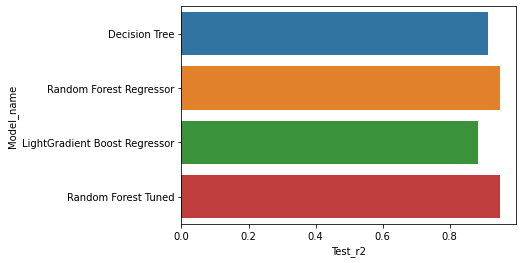

In [ ]:
#visualising our comparison df for Test R2
sns.barplot(y=updated_comparison_df['Model_name'], x = updated_comparison_df['Test_r2'])

Feature Importances

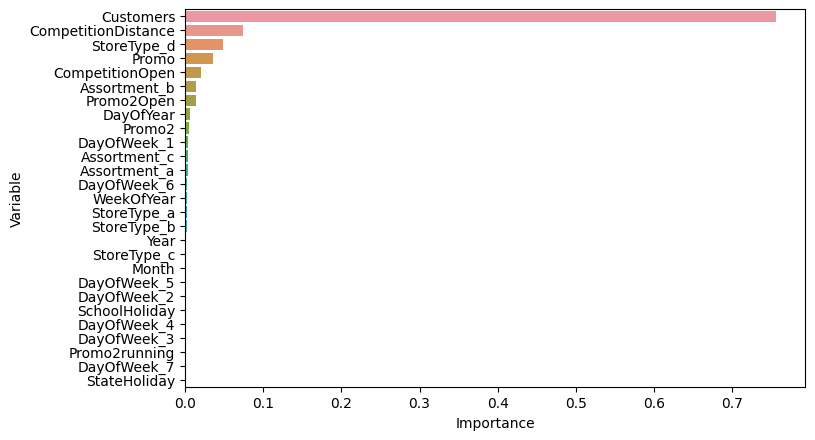

In [ ]:
#visualising feature importance of XGB
plt.rcParams.update({'figure.figsize':(8,5),'figure.dpi':100})
feature_imp = pd.DataFrame({"Variable": X_test.columns,"Importance": random_t})
feature_imp.sort_values(by="Importance", ascending=False, inplace = True)
sns.barplot(x=feature_imp['Importance'], y= feature_imp['Variable'])

Here, we can see that out of all the features present, customers is, among all, the most important one. Hence, influencing predictions the most.

In [ ]:
#test values
baseline_r2 = 0.913278	
random_r2 = 0.950859	
r_tuned_r2 = 0.951033	
lgbm_regressor_r2 = 0.885444	

In [ ]:
#improvement % 
improvement_r = ((random_r2 - baseline_r2)/baseline_r2)*100
print('Model Performance')
print(f'Improvement of {round(improvement_r,3)} % was seen in Random Forest against Decision Tree.')

Model Performance
Improvement of 4.115 % was seen in Random Forest against Decision Tree.


Random Forest Tuned vs Baseline and Random Forest Models

In [ ]:
#improvement % of tuned vs baseline

improvement_r = ((r_tuned_r2 - baseline_r2)/baseline_r2)*100
print('Model Performance')
print(f'Improvement of {round(improvement_r,3)} % was seen in Random Forest Tuned against Decision Tree.')

Model Performance
Improvement of 4.134 % was seen in Random Forest Tuned against Decision Tree.


In [ ]:
#improvement % of tuned vs simple random forest
improvement_r = ((r_tuned_r2 - random_r2)/random_r2)*100
print('Model Performance')
print(f'Improvement of {round(improvement_r,3)} % was seen in Random Forest Tuned against Simple Random Forest.')

Model Performance
Improvement of 0.018 % was seen in Random Forest Tuned against Simple Random Forest.


Oservation:
1. We observed maximum r2 for Random forest Tuned, which was only 0.018% more than the simple random forest model.
2. LGBM with its default parameters gave least r2.

## **Conclusion:**

We had sales data for around 2.5 years and we had got to predict, sales prices for next six weeks. After cleaning data, we took all the data points with some sales to split data into Test and Train data.

Thereafter, we performed StandardScaling techniques to get scale data and started fitting models on it. 

We selected decision tree as our base model, and then went ahead with RandomForest and LGBMRegressor models.

Random Forest with its parameters tuned, gave us the maximum r2 score, although it was least different from Random Forest model with default Parameters.

Some important conclusions drawn from the analysis are as follows:

1. There were more sales on Monday, probably because shops generally remain closed on Sundays which had the lowest sales in a week. This validates the hypothesis about this feature.

2. There is a high correlation between Customers and Sales.

3. Stores in close proximity had more sales than those with karge competition distance. This can be due to location and accessibility factors.

4. Store type B though being few in number had the highest sales average. The reasons include all three kinds of assortments specially assortment level b which is only available at type b stores and being open on sundays as well.

5. Outliers were genuine in our dataset, and that's why instead of treating them we let them there, and went with models which are not impacted by them.


**Suggestions/Recommendations**



*   Although this data is a bit old, given for years 2013, 2014 and 2015. Since then drug industry has changed dramatically, especially after Covid. One can easily assume, stores even large distances having great sales.

*   Still, if relevant, more store should be encouraged to have more assortment levels, as it leads to more sales.

*   Drug is an essential commodity, so if possible, stores to try keep it open even on holidays, even if it is for a very short time.

*   StoreType B should be increased in number.

